# 评估 SRCNN 模型

In [1]:
from utils.srcnn import SRCNN
net = SRCNN(upscale_factor=4,)
net

SRCNN(
  (img_upsampler): Upsample(scale_factor=4.0, mode='bicubic')
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
)

可以直接使用 [mmediting srcnn_x4 的权重](https://download.openmmlab.com/mmediting/restorers/srcnn/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth)：

In [2]:
from set_env import root_dir, temp_dir
from torch_book.web.stream import download
# 下载权重
url = "https://download.openmmlab.com/mmediting/restorers/srcnn/srcnn_x4k915_1x16_1000k_div2k_20200608-4186f232.pth"
weight_path = download(url, temp_dir/"weights")

项目根目录：/media/pc/data/lxw/ai/torch-book


更新权重信息：

In [3]:
import torch
state_dict = torch.load(weight_path, map_location=torch.device("cpu"), weights_only=False)['state_dict']
state_dict = {k.replace("generator.", "") :v for k, v in state_dict.items()}
net.load_state_dict(state_dict)

<All keys matched successfully>

查看效果：

torch.Size([1, 3, 84, 57]) torch.Size([1, 3, 336, 228]) torch.Size([1, 3, 336, 228])


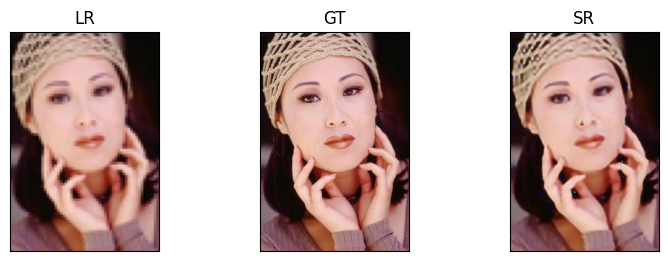

In [4]:
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import v2
from torch_book.data.cv.plot import GridFrame
from datasets.cv.utils.Set5 import PairedDataset

plt.ioff() # 关闭交互模式，防止弹出窗口阻塞代码运行

data_dir = root_dir/"tests/data/Set5"  # 数据根目录
scale = 4 # 放大倍数, 2, 3, 4
transform = v2.Compose([
    v2.ToDtype(torch.float32, scale=True), # 转换数据类型为 float32，并归一化到 [0, 1]
])
dataset = PairedDataset(
    scale,
    data_dir/"GTmod12",
    data_dir/f"LRbicx{scale}",
    transform=transform
)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
with torch.no_grad():
    for i, (lr, gt) in enumerate(data_loader):
        if i == 4:
            break
    pred = net(lr)
    print(lr.shape, gt.shape, pred.shape)
    results = [v2.ToPILImage()(x[0]) for x in [lr, gt, pred]]

    canvas =  GridFrame(1, 3, 2.5)
    gs, axes = canvas(results)
    [ax.set_title(title) for ax, title in zip(axes, ["LR", "GT", "SR"])]
    plt.close()
canvas.figure

## 评估指标

In [24]:
from dataclasses import dataclass
import torch.nn.functional as F

@dataclass
class Evaluator:
    pred: torch.Tensor
    target: torch.Tensor

    def mae(self, reduction="mean"):
        return F.l1_loss(self.pred, self.target, reduction=reduction)
    
    def psnr(self, max_value: int = 255):
        # 确保两张图像的形状相同
        assert self.pred.shape == self.target.shape, "两张图像的形状必须相同"
         # 计算均方误差（MSE）
        mse = F.mse_loss(self.pred, self.target)
        # 如果 MSE 为 0，说明两张图像完全相同，PSNR 为无穷大
        if mse == 0:
            return torch.inf
        # 计算 PSNR
        psnr = 20 * torch.log10(max_value / torch.sqrt(mse))
        return psnr

In [26]:
evaluator = Evaluator(pred, gt)

In [27]:
evaluator.psnr()

tensor(75.1743)

In [28]:
evaluator.mae()

tensor(0.0237)

In [38]:
a = test()

/media/pc/data/lxw/envs/anaconda3a/envs/ai/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
/media/pc/data/lxw/envs/anaconda3a/envs/ai/lib/python3.12/site-packages/onnxscript/converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [40]:
a == torch.inf

True